In [30]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sas

In [2]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
actual_stdev = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[int(key)] = act_vol
    actual_stdev[int(key)] = stdev_vol


In [3]:
data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

Loading polystyrene fit information.

In [4]:
background_files = [file for file in os.listdir('../../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)
    
power_law_fit_info = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}
cp_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_95p = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        cp_scales[key] = (0, [0,0])
        
guinier_porod_fit = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        

Loading Porod results

In [5]:
porod_files = [file for file in os.listdir('../data/sans/Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../data/sans/Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'CP scale' in column:
            cp_scales[key] = (value['best'], value['p95'])
        elif 'PS scale' in column:
            ps_scales[key] = (value['best'], value['p95'])
        elif 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

In [6]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    10.0: 'deeppink',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'forestgreen'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'forestgreen',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]


In [50]:
def plot_porod_fits(keys,sans_data_dict, usans_data_dict, zorders, label_dict, color_dict, filename, title=None, legend_title=None, size=6):
    
    make_colors = {}
    if type(color_dict) is list:
        print('converting color list')
        i = 0
        for key in keys:
            make_colors[key] = color_dict[i]
            i += 1
        color_dict = make_colors
    
    make_labels = {}
    if type(label_dict) is list:
        print('converting label list')
        i = 0
        for key in keys:
            make_labels[key] = label_dict[i]
            i += 1
        label_dict = make_labels
    
    zorders = [(x*20, x*20+10) for x in zorders]
            
            
    plt.figure(figsize=(6,6))
    i = 0
    for key in keys:
        if target[key] > 0:
            sans_data = sans_data_dict[key]

            plt.errorbar(sans_data.x, sans_data.y, yerr=sans_data.dy, zorder = zorders[i][0], label=label_dict[key], ms=size, color=color_dict[key], fmt='o', mec=color_dict[key], mfc='white',lw=1)

            
            
#             if key in usans_data_dict.keys():
#                 usans_data = usans_data_dict[key]
#                 plt.errorbar(usans_data.x, usans_data.y, yerr=usans_data.dy, zorder = zorders[i][0], label=None, ms=size, fmt='o', color=color_dict[key])
            
            qmin = 2e-2
            if cps[key] == 'RRe-P3HT':
                if target[key] > 1:
                    qmin = 4e-2
                elif target[key] > 0.1:
                    qmin = 3e-2
            porod_x = np.linspace(qmin,max(sans_data.x))
            kernel=load_model("power_law+power_law")

            sans_data.dx = sans_data.dx - sans_data.dx

            sans_model = Model(kernel, scale=1, background=backgrounds[key][0],  A_scale=ps_scales[key][0], B_scale=cp_scales[key][0], A_power=ps_porod_exp, B_power=4)
            sans_experiment = Experiment(data=sans_data, model=sans_model)
            sans_problem = FitProblem(sans_experiment)

            mask = np.where(sans_data.x >=qmin)
            #plt.plot(sans_data.x[mask], sans_problem.fitness.theory()[mask], color='yellow', zorder = zorders[i][1], linewidth=3)

            plt.plot(sans_data.x[mask], sans_problem.fitness.theory()[mask], color=color_dict[key], zorder = zorders[i][1], linewidth=3, path_effects=[pe.Stroke(linewidth=5, foreground='white'), pe.Normal()])

            i+=1
            
        else:
            sans_data = sans_data_dict[key]

            plt.errorbar(sans_data.x, sans_data.y, yerr=sans_data.dy, zorder = zorders[i][0], label=label_dict[key], ms=size, fmt='o', color=color_dict[key], mec=color_dict[key], mfc='white')

#             if key in usans_data_dict.keys():
#                 usans_data = usans_data_dict[key]
#                 plt.errorbar(usans_data.x, usans_data.y, yerr=usans_data.dy, zorder = zorders[i][0], label=None, ms=size, fmt='o', color=color_dict[key])

            qmin = 2e-2
            if cps[key] == 'RRe-P3HT':
                if target[key] > 1:
                    qmin = 4e-2
                elif target[key] > 0.1:
                    qmin = 3e-2
            porod_x = np.linspace(qmin,max(sans_data.x))
            
            if key in rgs.keys():
                kernel=load_model("guinier_porod")
                sans_model=Model(kernel, scale=ps_scales[key][0], background=backgrounds[key][0], porod_exp=ps_porod_exp, s=ps_s, rg=rgs[key][0])
            else:
                kernel=load_model("power_law")
                sans_model = Model(kernel, scale=ps_scales[key][0], background=backgrounds[key][0], power=ps_porod_exp)

            sans_data.dx = sans_data.dx - sans_data.dx

            sans_experiment = Experiment(data=sans_data, model=sans_model)
            sans_problem = FitProblem(sans_experiment)

            mask = np.where(sans_data.x >= qmin)
            plt.plot(sans_data.x[mask], sans_problem.fitness.theory()[mask], label='Porod Fit', color=color_dict[key], zorder = zorders[i][1], linewidth=3, path_effects=[pe.Stroke(linewidth=5, foreground='white'), pe.Normal()])
            i+=1
            
    
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
    plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)
    
    legend = plt.legend(fontsize=12, title=legend_title)
    legend.get_title().set_fontsize('12')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim(1e-02, 1e8)
    plt.xlim(0.0007, 0.3)

    if title is not None:
        plt.title(title, fontsize=16)
    
    plt.tight_layout()

    plt.savefig(filename, dpi=600)
    
    plt.close()

In [51]:
save_loc = '../../data/sans/Porod_analysis/porod_figures/fits/'
os.makedirs(save_loc, exist_ok=True)

plot_porod_fits([1,2,3,4,5,21],sans_data,usans_data,[5,4,3,2,1,6],wt_names,wt_colors, save_loc + 'RReP3HT_CF_1.png',title='RRe-P3HT in PS-D8 from Chloroform')
plot_porod_fits([6,7,8,9,10,21],sans_data,usans_data,[5,4,3,2,1,6],wt_names,wt_colors, save_loc +'RRaP3HT_CF_1.png',title='RRa-P3HT in PS-D8 from Chloroform')
plot_porod_fits([11,12,13,14,15,21],sans_data,usans_data,[5,4,3,2,1,6],wt_names,wt_colors, save_loc +'P3DDT_CF.png',title='P3DDT in PS-D8 from Chloroform')
plot_porod_fits([16,17,18,19,20,21],sans_data,usans_data,[5,4,3,2,1,6],wt_names,wt_colors, save_loc +'PQT12_CF.png',title='PQT-12 in PS-D8 from Chloroform')

plot_porod_fits([101,102,103,104,105,106,107,113],sans_data,usans_data,[7,6,5,4,3,2,1,8],wt_names,wt_colors, save_loc +'RReP3HT_CF_2.png',title='RRe-P3HT in PS-D8 from Chloroform')
plot_porod_fits([108,109,110,111,112,114],sans_data,usans_data,[5,4,3,2,1,6],wt_names,wt_colors, save_loc +'RReP3HT_CF_3.png',title='RRe-P3HT in PS-D8 from Chloroform')


plot_porod_fits([22,23,24,28],sans_data,usans_data,[3,2,1,4],wt_names,wt_colors, save_loc +'RReP3HT_BB_1.png',title='RRe-P3HT in PS-D8 from Bromobenzene')
plot_porod_fits([25,26,27,28],sans_data,usans_data,[3,2,1,4],wt_names,wt_colors, save_loc +'P3DDT_BB.png',title='P3DDT in PS-D8 from Bromobenzene')

plot_porod_fits([29,30,31,35],sans_data,usans_data,[3,2,1,4],wt_names,wt_colors, save_loc +'RReP3HT_Tol_1.png',title='RRe-P3HT in PS-D8 from Toluene')
plot_porod_fits([32,33,34,35],sans_data,usans_data,[3,2,1,4],wt_names,wt_colors, save_loc +'P3DDT_Tol.png',title='P3DDT in PS-D8 from Toluene')


plot_porod_fits([203,113],sans_data,usans_data,[1,2],wt_names,wt_colors, save_loc +'RRaP3HT_CF_2.png',title='RRa-P3HT in PS-D8 from Chloroform')
plot_porod_fits([205,206,114],sans_data,usans_data,[2,1,3],wt_names,wt_colors, save_loc +'RRaP3HT_CF_3.png',title='RRa-P3HT in PS-D8 from Chloroform')

plot_porod_fits([301,302,303,304,305,310],sans_data,usans_data,[5,4,3,2,1,6],wt_names,wt_colors, save_loc +'RReP3HT_BB_2.png',title='RRe-P3HT in PS-D8 from Bromobenzene')
plot_porod_fits([306,307,309],sans_data,usans_data,[2,1,3],wt_names,wt_colors, save_loc +'RReP3HT_BB_3.png',title='RRe-P3HT in PS-D8 from Bromobenzene')

plot_porod_fits([402,401,404,403,405,409],sans_data,usans_data,[5,4,3,2,1,6],wt_names,wt_colors, save_loc +'RReP3HT_Tol_2.png',title='RRe-P3HT in PS-D8 from Toluene')
plot_porod_fits([406,407,408,409],sans_data,usans_data,[3,2,1,4],wt_names,wt_colors, save_loc +'RReP3HT_Tol_3.png',title='RRe-P3HT in PS-D8 from Toluene')

plot_porod_fits([501,502,503,504,505,506],sans_data,usans_data,[5,4,3,2,1,6],wt_names,wt_colors, save_loc +'RReP3HT_CF_SLOW.png',title='RRe-P3HT in PS-D8 from Chloroform - Slow Dry')

Calculating interfacial concentration, S/V, by extracting the conjugated polymer scale, sld contrast and the actual volume fraction from UV-Vis.

(1e-09, 10.0)

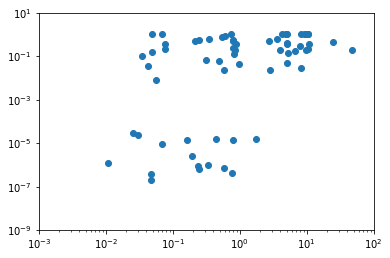

In [9]:
# will not utilize the fits with a very small scale of the conjugated polymer component
# this is indicating that we can not deconvolute the conjugated polymer from the 
# polystyrene contribution and this will result in outliers

wt_list = []
frac_list = []
for key in cp_scales.keys():
    if key in actual.keys():
        cp_val = cp_scales[key][0]
        ps_val = ps_scales[key][0]
        wt_list.append(actual[key])
        frac_list.append(cp_val/(cp_val + ps_val))
        
plt.scatter(wt_list, frac_list)
plt.yscale('log')
plt.xscale('log')

plt.xlim(1e-3,1e2)
plt.ylim(1e-9,1e1)

In [10]:
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       'Polystyrene-D8':6.407,
       'Polystyrene-H8':1.426}

contrast = {}
for key in actual.keys():
    sld_cp = slds[cps[key]]*10**(-6)
    sld_ps = slds[matrix[key]]*10**(-6)
    contrast[key] = (sld_cp - sld_ps)**2


Sv = {}
Sv_95 = {}
for key in actual.keys():
    if key in cp_scales.keys():
        cp_scale = cp_scales[key][0]
        cp_95 = cp_scales[key][1]
        ps_scale = ps_scales[key][0]
        frac = cp_scale/(cp_scale+ps_scale)
        if frac > 1e-3:
            Sv[key] = cp_scale/(2*np.pi*contrast[key]*(actual[key]/100)*10**8)
            Sv_max = cp_95[1]/(2*np.pi*contrast[key]*(actual[key]/100)*10**8)
            Sv_min = cp_95[0]/(2*np.pi*contrast[key]*(actual[key]/100)*10**8)
            Sv_95[key] = (Sv_min, Sv_max)
            
min_sv = min(Sv.values())
max_sv = max(Sv.values())

print(min_sv, max_sv)


7.204234751095882e-05 0.016184775804975186


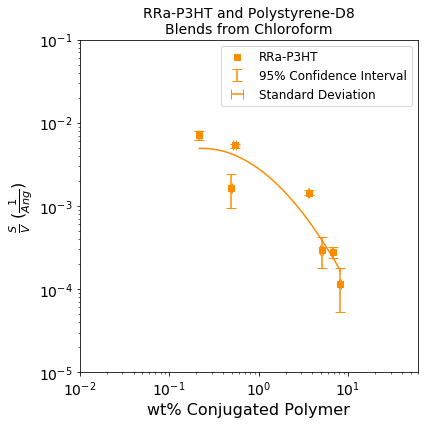

In [11]:
plt.figure(figsize=(6,6))

keys = [6,7,8,9,10,201,202,203,204,205,206]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual[key])
        conc_stdev.append(actual_stdev[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'RRa-P3HT', c='darkorange', marker='s')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkorange', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkorange', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkorange', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('RRa-P3HT and Polystyrene-D8\nBlends from Chloroform', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_RRaP3HT_CF.png', dpi=300)


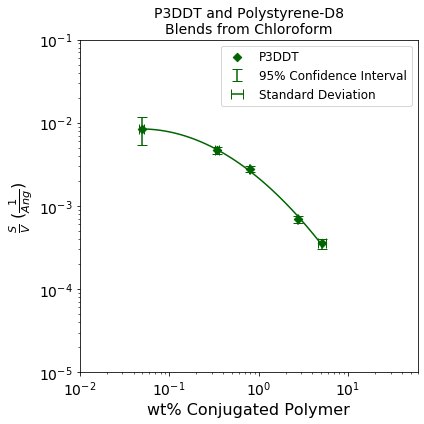

In [12]:
plt.figure(figsize=(6,6))

keys = [11,12,13,14,15]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual[key])
        conc_stdev.append(actual_stdev[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'P3DDT', c='darkgreen', marker='D')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkgreen', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkgreen', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkgreen', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('P3DDT and Polystyrene-D8\nBlends from Chloroform', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_P3DDT_CF.png', dpi=300)


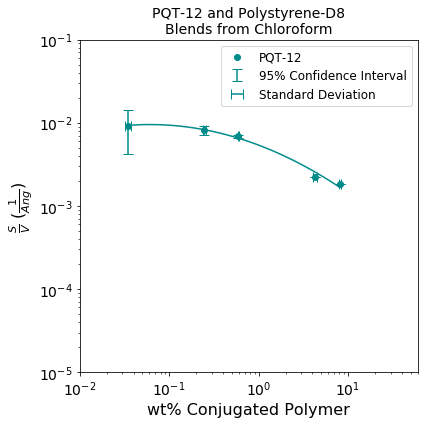

In [13]:
plt.figure(figsize=(6,6))

keys = [16,17,18,19,20]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual[key])
        conc_stdev.append(actual_stdev[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'PQT-12', c='darkcyan', marker='o')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkcyan', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkcyan', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkcyan', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('PQT-12 and Polystyrene-D8\nBlends from Chloroform', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_PQT12_CF.png', dpi=300)


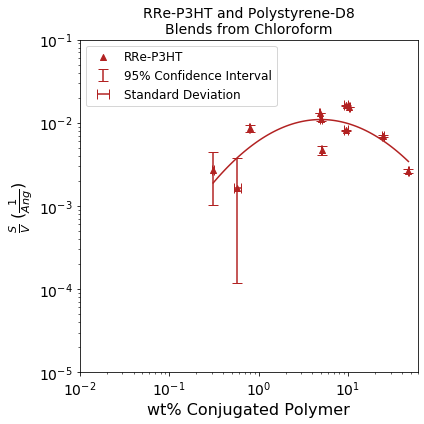

In [14]:
plt.figure(figsize=(6,6))

keys = [1,2,3,4,5,101,102,103,104,105,106,107,108,109,110,111,112,113,114]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual[key])
        conc_stdev.append(actual_stdev[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'RRe-P3HT', c='firebrick', marker='^')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='firebrick', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='firebrick', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='firebrick', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('RRe-P3HT and Polystyrene-D8\nBlends from Chloroform', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_RReP3HT_CF.png', dpi=300)


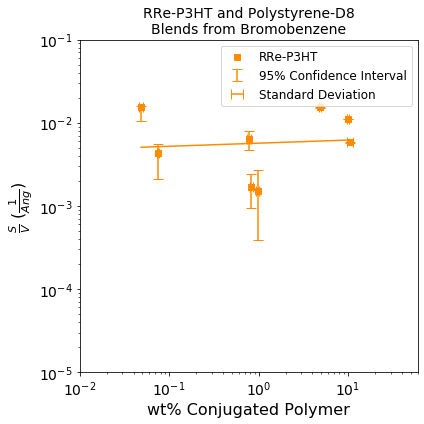

In [19]:
plt.figure(figsize=(6,6))

keys = [22,23,24,301,302,303,304,305,306,307,308,309,310]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual[key])
        conc_stdev.append(actual_stdev[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'RRe-P3HT', c='darkorange', marker='s')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkorange', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkorange', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 1)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkorange', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('RRe-P3HT and Polystyrene-D8\nBlends from Bromobenzene', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_RReP3HT_BB.png', dpi=300)


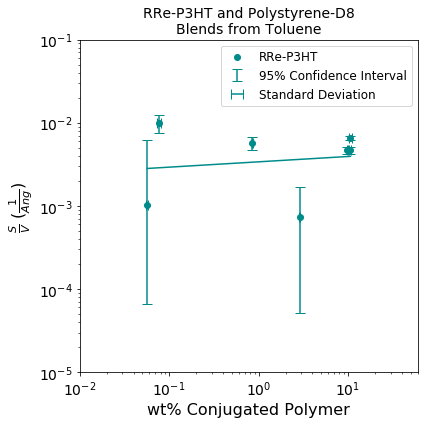

In [20]:
plt.figure(figsize=(6,6))

keys = [29,30,31,401,402,403,404,405,406,407,408,409,410]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual[key])
        conc_stdev.append(actual_stdev[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'RRe-P3HT', c='darkcyan', marker='o')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkcyan', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkcyan', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 1)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkcyan', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('RRe-P3HT and Polystyrene-D8\nBlends from Toluene', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_RReP3HT_Tol.png', dpi=300)


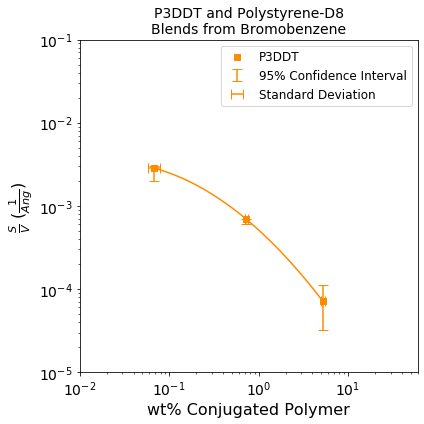

In [17]:
plt.figure(figsize=(6,6))

keys = [25,26,27]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual[key])
        conc_stdev.append(actual_stdev[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'P3DDT', c='darkorange', marker='s')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkorange', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkorange', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkorange', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('P3DDT and Polystyrene-D8\nBlends from Bromobenzene', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_P3DDT_BB.png', dpi=300)


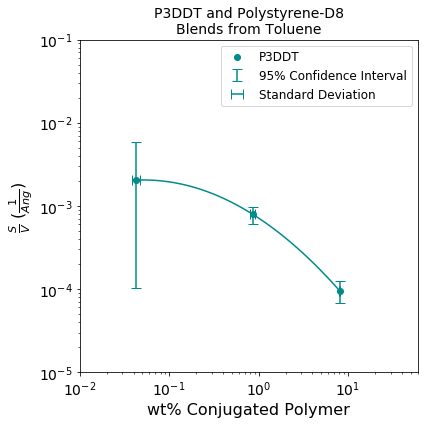

In [18]:
plt.figure(figsize=(6,6))

keys = [32,33,34]
conc = []
conc_stdev = []
sv_list = []
sv_middle = []
sv_size = []
for key in keys:
    if key in Sv.keys():
        conc.append(actual[key])
        conc_stdev.append(actual_stdev[key])
        sv_list.append(Sv[key])
        sv_max = Sv_95[key][1]
        sv_min = Sv_95[key][0]
        sv_middle.append((sv_max + sv_min)/2)
        sv_size.append((sv_max - sv_min)/2)
plt.scatter(conc, sv_list, label = 'P3DDT', c='darkcyan', marker='o')
plt.errorbar(conc, sv_middle, yerr=sv_size, capsize=5, c='darkcyan', label='95% Confidence Interval', fmt='none')
plt.errorbar(conc, sv_list, xerr=conc_stdev, capsize=5, c='darkcyan', label='Standard Deviation', fmt='none')

fit_params = np.polyfit(np.log(conc), np.log(sv_list), 2)
fit_function = np.poly1d(fit_params)
x_fit = np.linspace(min(np.log(conc)), max(np.log(conc)), 100)
y_fit = fit_function(x_fit)
plt.plot(np.exp(x_fit), np.exp(y_fit), c='darkcyan', label=None)

plt.xscale('log')
plt.yscale('log')

plt.xlim(0.01, 60)
plt.ylim(1e-5,1e-1)
#plt.ylim(-0.005, max(Sv.values()))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(fontsize = 12)

plt.xlabel(r'wt% Conjugated Polymer', fontsize=16)
plt.ylabel(r'$\frac{S}{V}$ ($\frac{1}{Ang}$)', fontsize=16)

plt.title('P3DDT and Polystyrene-D8\nBlends from Toluene', fontsize=14)

plt.tight_layout()

plt.savefig('../../data/sans/Porod_analysis/porod_figures/sv_plots/WithPSContribution_P3DDT_Tol.png', dpi=300)
